## MNIST Practice

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io # turn into array
import numpy as np
from torchvision import transforms, datasets
from torch import nn, optim, autograd
import torch
from torch.utils.data import sampler, DataLoader
import tqdm
from sklearn import metrics
import seaborn as sns

## Normalizing Function

In [11]:
mean = (0.5, )
std = (1., )

normalized = [transforms.ToTensor(), transforms.Normalize(mean, std)]

normalized = transforms.Compose(normalized)

In [12]:
train = datasets.MNIST("", train = True, transform=normalized)
test = datasets.MNIST("", train = False, transform= normalized)

In [13]:
batch_size = 200
validation_split = 0.2
shuffle_dataset = True
random_seed = 123

train_len = len(train)
indices = list(range(train_len))
split = int(np.floor(validation_split*train_len))


np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = sampler.SubsetRandomSampler(train_indices)
val_sampler = sampler.SubsetRandomSampler(val_indices)

train_loader = DataLoader(train, batch_size, sampler=train_sampler)
val_loader = DataLoader(train, batch_size, sampler=val_sampler)
test_loader = DataLoader(test, batch_size, shuffle=False)

In [14]:
dataiter = iter(train_loader)


In [15]:
class Net(nn.Module, ):

    def __init__(self, inputsize, hiddensize, numclasses):

        super(Net, self).__init__()

        self.conv = nn.Conv1d(inputsize, inputsize, 3)

        self.fc1 = nn.Linear(inputsize, hiddensize)
        self.fc2 = nn.Linear(hiddensize, hiddensize)
        self.fc3 = nn.Linear(hiddensize, numclasses)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        #out = self.conv(x)

        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)

        return out

        
        


net = Net(28*28, 20, 10)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters()) # learning rate

In [17]:
def get_accuracy(loader, my_net):
  correct = 0
  total = 0
  for images, labels in loader:
      images = autograd.Variable(images.view(-1, 28*28))
      outputs = my_net(images)
      _, predicted = torch.max(outputs.data, 1)  
      total += labels.size(0)               
      correct += (predicted == labels).sum()

  return 100 * correct / total

## Training loop

In [18]:
num_epochs = 10

loss_tracker = []

for epoch in range(num_epochs):
  # Initialize random value for loss just for displaying purposes
  loss = torch.tensor([100])

  # Using the tqdm for nice training visuals
  progress_bar = tqdm.notebook.tqdm(train_loader, ncols=1000)

  # We load a batch of images and their corresponding labels here and continue
  # until we trained on all batches.
  for i, (images, labels) in enumerate(progress_bar):
    # Convert torch tensor to a vector of size 784 in order to send it to input
    # layer
    images = autograd.Variable(images.view(-1, 28*28))
    labels = autograd.Variable(labels)

    # Clear the gradients before performing backpropagation
    optimizer.zero_grad()

    # Perform the forward pass - this call of net calls the forward() fn
    outputs = net(images)

    # Compute loss on the output of the forward pass and desired label
    loss = criterion(outputs, labels)

    # Compute the gradients with respect to the loss function
    loss.backward()   

    # Update the weights in the neural network using the optimizer/backprop
    optimizer.step()

    
    # Track losses for plotting later
    loss_tracker.append(loss.data)                                  

    # Visualization code
    if (i+1) % 100 == 0 or (i+1) == len(train_loader):   
      progress_bar.set_description('Epoch [%d/%d], Step [%d/%d], Val Acc: %d, Training Loss: %.4f'
              %(epoch+1, num_epochs, i+1, len(train_loader), \
                get_accuracy(val_loader, net), loss.data))

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [19]:
train_acc = get_accuracy(train_loader, net)
test_acc = get_accuracy(test_loader, net)
print("The training accuracy is: {:.2%} and the testing accuracy is: {:.2%}".format(train_acc/100,test_acc/100))

The training accuracy is: 92.49% and the testing accuracy is: 92.14%


### Confusion Matrix

In [63]:
def get_conf_mat(loader, my_net):
  mat = np.zeros((10,10))
  for images, labels in loader:
      images = autograd.Variable(images.view(-1, 28*28))
      outputs = my_net(images)
      _, predicted = torch.max(outputs.data, 1)  
      mat += metrics.confusion_matrix(labels, predicted)
  mat = mat/100
  return mat, metrics.ConfusionMatrixDisplay(mat)

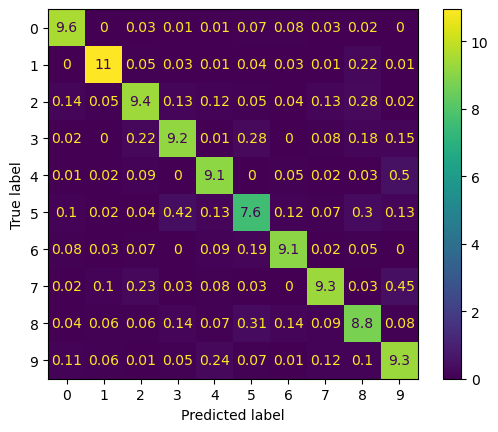

In [21]:
get_conf_mat(test_loader, net).plot()

In [23]:
test_loader = torch.utils.data.DataLoader(test, batch_size=1)


misclassified_images = []
misclassified_labels = []
misclassified_preds = []
for images, labels in test_loader:
    images = autograd.Variable(images.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  

    if predicted != labels:
      misclassified_images.append(images.view(1, 28, 28))
      misclassified_labels.append(labels)
      misclassified_preds.append(predicted)

Text(0.5, 1.0, 'Should be 7, predicted as 2')

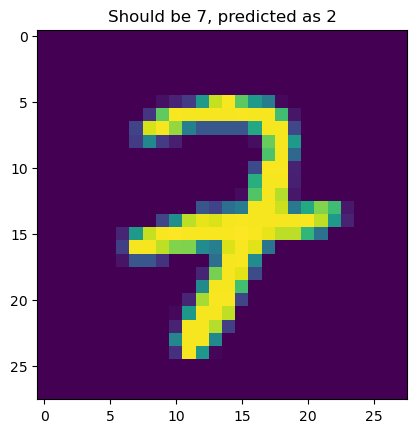

In [50]:
idx = np.random.randint(len(misclassified_images))
label = misclassified_labels[idx]; pred = misclassified_preds[idx]
plt.imshow(misclassified_images[idx].squeeze())
plt.title("Should be {}, predicted as {}".format(int(label), int(pred)))

### Commonly mispredicted Numbers

In [87]:
test_loader = DataLoader(test, batch_size, shuffle=False)

mat, plot = get_conf_mat(test_loader, net)

In [117]:
def common_mistakes(mat):
    for i in range(10):
        for j in range(10):
            if i == j:
                mat[i,j] = 0
    return np.vstack((np.arange(10), np.argmax(mat, 1))), np.max(mat,1)

In [118]:
x, _ = common_mistakes(mat)

x

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [6, 8, 8, 5, 9, 3, 5, 9, 5, 4]])

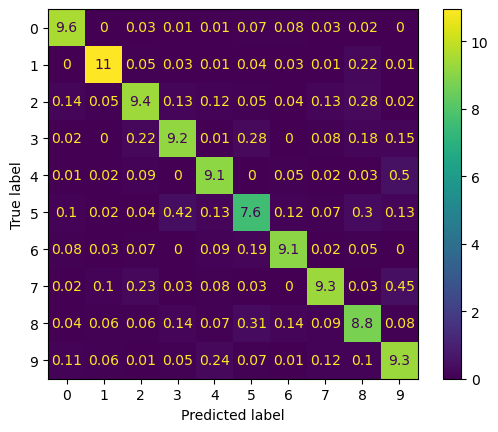

In [70]:
plot.plot()